

# Community Detection and Modularity Maximization

In a [previous lecture](06-modularity.qmd), we introduced the idea of *assortativity* in networks. Roughly, a network is assortative with respect to some attribute if nodes which share that attribute are more likely to be connected to each other than to nodes without that attribute.

Our data for this set of lecture notes is a data set of social interactions between students at a French high school in 2012. The data was collected by @fournet2014contact as part of the [SocioPatterns project](http://www.sociopatterns.org/). Students were given wearable sensors which would ping when two students were in close proximity and facing each other. Each of these pings is an edge in the raw data, although in our processing for this lecture we simplify the data set down so that there is an edge between each pair of students who interacted at all during the data collection period.

In this high school, students were tracked into one of five classes:

1. MP\*1 and MP\*2 were two classes focusing on mathematics and physics.
2. PC and PC\* were two classes focusing on physics and chemistry.
3. PSI\* was one class focusing on engineering.

We might reasonably expect that students in the same class would interact more with each other than with students in other classes. Let's acquire the data and visualize the network to begin to develop a feel for this idea.

In [1]:

import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D # for legend later
plt.style.use('seaborn-v0_8-whitegrid')

def unweight(G):
    for source, target in G.edges():
        G[source][target]['weight'] = 1
    return G

def acquire_contact_data():
    url = "https://raw.githubusercontent.com/network-science-notes/network-science-notes.github.io/refs/heads/main/data/contact-high-school.csv"

    contact = pd.read_csv(url, sep = "\t", names = ["time", "source", "target", "class_s", "class_t"])[["source", "target", "class_s", "class_t"]]

    G = nx.from_pandas_edgelist(contact)

    class_labels = contact[["source", "class_s"]].drop_duplicates(subset=['source'])
    class_labels = dict(zip(class_labels["source"], class_labels["class_s"]))
    more_class_labels = contact[["target", "class_t"]].drop_duplicates(subset=['target'])
    more_class_labels = dict(zip(more_class_labels["target"], more_class_labels["class_t"]))

    class_labels.update(more_class_labels)

    classes = ["MP*1", "MP*2", "PC", "PC*", "PSI*"]

    class_to_int = {class_label : i for i, class_label in enumerate(classes)}

    class_labels = {node : class_to_int[label] for node, label in class_labels.items()}

    nx.set_node_attributes(G, class_labels, "class")

    G = nx.convert_node_labels_to_integers(G)
    G = unweight(G)
    return G

def draw_graph(G, clusters = None, ax = None, legend = True):


    node_kwargs = {"node_size" : 50, "edgecolors" : 'black'}
    if clusters is not None:
        num_clusters = np.unique(list(clusters.values())).shape[0]
        cluster_to_color = [plt.cm.Set3(i) for i in range(num_clusters)]
        node_kwargs["node_color"] = [cluster_to_color[clusters[i]] for i in G.nodes()]
    edge_kwargs = {"edge_color" : "gray", "alpha" : 0.3}
    pos = nx.spring_layout(G)
    nx.draw_networkx_edges(G, pos, ax = ax, **edge_kwargs)
    nx.draw_networkx_nodes(G, pos, ax = ax, **node_kwargs)
    off = ax.axis("off")

    if (clusters is not None) and legend:
        classes = ["MP*1", "MP*2", "PC", "PC*", "PSI*"]
        legend_elements = [Line2D([0], [0], marker='o', color="black", label=classes[i], lw=0, markerfacecolor=plt.cm.Set3(i), markersize=10) for i in range(5)]

        ax.legend(handles=legend_elements, loc='upper right')

def labels_to_array(z, G):
    if isinstance(z, dict):
        z = np.array([z[node] for node in G.nodes])
    elif isinstance(z, list):
        z = np.array(z)
    return z

::: {.column-margin}

This hidden code cell implements a number of utilities for processing and node labels associated with them. It also has a lot of plotting implementations.

:::

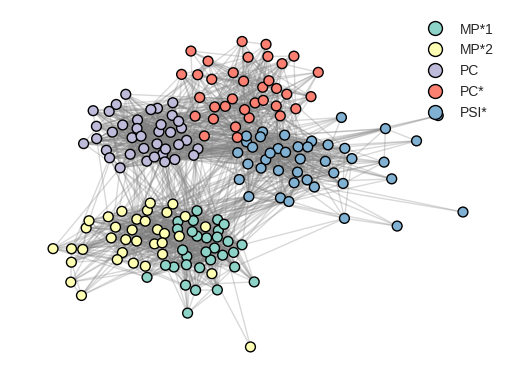

In [3]:
G = acquire_contact_data()
clusters = nx.get_node_attributes(G, "class")
fix, ax = plt.subplots(1,1)
draw_graph(G, clusters = clusters, ax = ax)

There are 5 classes in the network: MP\*1, MP\*2, PC, PC\*, and PSI\*. Visual inspection of the plot suggests that the network may be assortative with respect to class: there are many edges between nodes of the same class, and fewer edges between nodes of different classes. There is even some *nested* assortative structure. The MP\*1 and MP\*2 classes seem to form a distinct subgraph. Students in MP\*1 are more likely interact amongst themselves, but if they do interact with anyone outside their own class, it is likely to be with students in MP\*2.

## Recall: Measuring Assortativity with Modularity

Recall that we can quantify the extent to which a network is assortative with respect to some attribute by calculating the *modularity* of the network with respect to that attribute. Let $\mathcal{Z}$ be a finite set of possible node labels, and let $\mathbf{z} \in \mathcal{Z}^n$ be a vector whose $i$th entry gives the label of the $i$th node. Then, the modularity functional of $G$ with respect to $\mathbf{z}$ as defined by @newman2004finding is given by the formula

$$
\begin{aligned}
    Q(G, \mathbf{z}) = \frac{1}{2m} \sum_{i,j \in N} \left[ a_{ij} - \frac{k_i k_j}{2m} \right] \delta_{z_i z_j} \,,
\end{aligned}
$$

This formula can be motivated in several ways.

1. **Comparison to random graphs**: $Q$ is a comparison of $a_{ij}$ to the expected number of edges between nodes $i$ and $j$ if edges were placed at random while approximately preserving the degree sequence (This point is surprisingly subtle; see @chodrow2020moments for a discussion of some of the difficulties.).
2. **Dynamical stability**: $Q$ is a measure of the tendency of random walks on the graph $G$ to stay within the same community; see @delvenne2010stability.
3. **Statistical inference**: $Q$ is a term in the objective function for a statistical inference task in which we try to infer the labels $\mathbf{z}$ from the graph structure; see @newman2016equivalence.


We often informally say that the network is *assortative* or *has modular structure* when $Q$ is substantially larger than 0. [The question of what counts as "substantially larger" can be tricky; for example; see discussion in @zhang2014scalable for cases in which Erdős–Rényi random graphs can have high modularity with respect to a carefully-chosen partition.]{.aside}

Networkx implements a function to compute the modularity, but it's not difficult to implement our own either. We'll structure our function to accept a vector of characters giving the class labels.  

In [8]:
def modularity(G,z):
  # dict to array to node labels
  z= labels_to_array(z, G)

  # make matrices
  A = nx.to_numpy_array(G)
  k = A.sum(axis = 1)
  m = G.number_of_edges()

  # compute matrix of Kroecker deltas
  delta = z[:, None] == z[None, :]

  return 1/(2*m) * ((A - np.outer(k,k)/(2*m)) * delta).sum()

Now let's try calling our function to find the modularity of the graph and its labels:

In [9]:
modularity(G, clusters)

0.5039115128642156

Let's do a quick check against the built-in implementation of modularity in Networkx. This implementation works just a bit differently: we need to pass a list of sets in which each set represents a community.

In [10]:
communities = [{node for node in G.nodes() if clusters[node] == i} for i in range(5)]
nx.community.modularity(G, communities)

0.5039115128642155

Our answers agree!

## The Community Detection Problem

In the community detection problem, we consider a graph $G$ which we *suspect* to have some interesting modular structure, but we do not have access to the label vector $\mathbf{z}$. Instead, we attempt to *find* a good label vector based on the graph structure itself. [This kind of task is also often called "graph clustering" or "graph partitioning." The idea that networks have community structure and that algorithms can find this structure was popularized by @girvan2002community.]{.aside}

::: {.column-margin}

So, in the community detection problem, we have access to an *unlabeled graph* like this one.

In [ ]:
fig, ax = plt.subplots(1, 1)
draw_graph(G, ax = ax)

We'd like to find a "good" partition of the nodes.

:::

### Community Detection as Optimization

Many algorithms for community detection are based on the idea of optimization. The goal is to formulate a function $R(G, \mathbf{z})$ with two main properties:

1. $R(G, \mathbf{z})$ is large when $\mathbf{z}$ is a "good" partition of the graph.
2. It is feasible to find a partition of $\mathbf{z}$ which gives a large value of $R(G, \mathbf{z})$ in practical computational time.

Roughly, criterion 1 says that we are "optimizing the right thing," while criterion 2 says that "optimizing the right thing" is in fact computationally feasible. Due to its many useful interpretations, the modularity $Q$ has been a very popular choice of objective functions for community detection. In [later notes](19-spectral-clustering.qmd), we'll explore an alternative objective function.  

## A Community Detection Algorithm: Greedy Agglomerative Clustering

Unfortunately, exactly maximizing the modularity is NP-hard [@brandes2007modularity], and so we need to consider tractable heuristic algorithms that we hope may lead us to solutions which are close to optimal.

One simple algorithm for heuristic modularity maximization is the *greedy agglomerative clustering* algorithm. The idea is to start with each node in its own community, and then iteratively swap the labels of nodes until no improvement in the modularity can be obtained. An important computational feature of this algorithm is that we don't need to always recalculate the modularity from scratch. Instead, we can simply *update* the modularity with the change that results from swapping a node $h$ from community $x$ to community $y$. Let $\mathbf{z}$ be the label vector before the swap and let $\mathbf{z}'$ be the label vector after the swap. Then,

$$
\begin{aligned}
    Q(G, \mathbf{z}') - Q(G, \mathbf{z}) &=  \frac{1}{2m}\sum_{i\neq j} \left[ a_{ij} - \frac{k_ik_j}{2m} \right] \delta_{z_i', z_j'} - \frac{1}{2m}\sum_{i\neq j} \left[ a_{ij} - \frac{k_ik_j}{2m} \right] \delta_{z_i, z_j} \\
    &= \frac{1}{2m}\sum_{i\neq j} \left[ a_{ij} - \frac{k_ik_j}{2m} \right] \left(\delta_{z_i', z_j'} - \delta_{z_i, z_j}\right)\;.
\end{aligned}
$$

We only have $\delta_{z_i', z_j'} - \delta_{z_i, z_j} \neq 0$ when either $i$ or $j$ is equal to $h$. If $i = h$, then $z_i = x$, $z_i' = y$, and $z_j' = z_j$ for all $j \neq h$. So,

$$
\begin{aligned}
    Q(G, \mathbf{z}') - Q(G, \mathbf{z}) &= \frac{1}{2m}\left(\sum_{j\neq h} \left[ a_{hj} - \frac{k_hk_j}{2m} \right] \left(\delta_{y, z_j} - \delta_{x, z_j}\right) + \sum_{i\neq h} \left[ a_{ih} - \frac{k_ik_h}{2m} \right] \left(\delta_{z_i, y} - \delta_{z_i, x}\right) \right) \\
    &= \frac{1}{m}\left(\sum_{j\neq h} \left[ a_{hj} - \frac{k_hk_j}{2m} \right] \left(\delta_{y, z_j} - \delta_{x, z_j}\right)  \right)\;,
\end{aligned}
$$

where in the second line we have used the fact that the two sums appearing are just re-indexed copies of each other. Here's our implementation:

In [11]:
def greedy_clustering(G, num_steps = int(1e4)):

    # initialize every node in its own cluster
    labels = np.arange(G.number_of_nodes())

    # compute the modularity initially -- we'll update it as we go
    progress = [modularity(G, labels)]

    # matrices and vectors we'll need
    m = G.number_of_edges()
    A = nx.to_numpy_array(G)
    k = A.sum(axis = 1)

    # main loop
    for _ in range(num_steps):

        # pick two nodes at random and retrieve their labels
        i, j = np.random.choice(G.number_of_nodes(), 2, replace = False)

        # prospective swap is that i will change its label from x to y
        x = labels[i]
        y = labels[j]

        if x == y:
            continue

        else:
            # compute the change in modularity of the prospective swap
            change_vec = 1/m *  ((A[i] - k[i]*k/(2*m))*(1*(y == labels) - 1*(x == labels)))
            change_vec[i] = 0 # zero out the term corresponding to i
            change = change_vec.sum()

            # if positive, update the labels and store the new modularity for visualization later
            if change > 0:
                labels[i] = y
                progress.append(progress[-1] + change)

    # postprocessing: we need to convert the labels into a dict for visualization etc.

    distinct_labels = np.unique(labels)
    label_map = {int(distinct_label) : i for i, distinct_label in enumerate(distinct_labels)}

    greedy_clusters = {i : label_map[label] for i, label in enumerate(labels)}

    return greedy_clusters, np.array(progress)

Let's run our algorithm...

In [12]:
greedy_clusters, progress = greedy_clustering(G, num_steps = int(1e4))

...and visualize how we did.

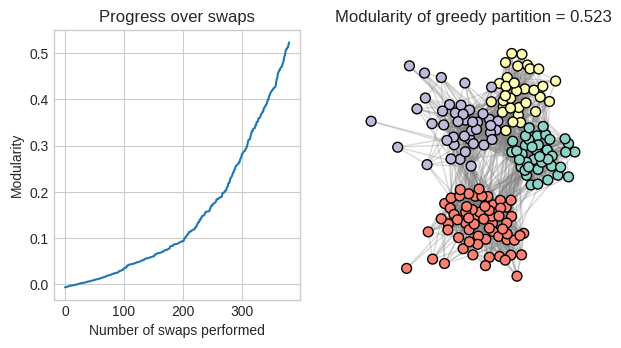

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (7, 3.5))

ax[0].plot(progress)
ax[0].set(xlabel = "Number of swaps performed", ylabel = "Modularity", title = "Progress over swaps")

ax[1].set(title = f"Modularity of greedy partition = {modularity(G, greedy_clusters):.3f}")
ax[1].axis("off")
draw_graph(G, clusters = greedy_clusters, ax = ax[1], legend = False)

This algorithm required several hundred executed swaps (and thousands of non-executed swaps) in order to achieve the visualized clustering. The clusters shown actually achieve a modularity that is comparable to the original clustering.



## Validation of Community Detection Algorithms

How do we tell whether a community detection algorithm is "good"? One standard way is to compare the clusters found by that algorithm to the true clusters, when such true clusters are available. [Though see @peel2017ground for a discussion of the limitations of this approach.]{.aside} Generally, we'd like to use a function $f(\mathbf{z}, \mathbf{z}')$ which measures the similarity between the two label vectors $\mathbf{z}$ and $\mathbf{z}'$; we'd have $f(\mathbf{z}, \mathbf{z}') = 1$ when the two vectors are identical (up to permutations of labels) and $f(\mathbf{z}, \mathbf{z}') = 0$ when the two vectors are completely uncorrelated.  

There are several metrics which are appropriate to this task. We'll illustrate one standard such vector, the *normalized mutual information* or NMI. The NMI has formula

$$
\begin{aligned}
    \text{NMI}(\mathbf{z}, \mathbf{z}') = 2 \frac{I(\mathbf{z}, \mathbf{z}')}{H(\mathbf{z}) + H(\mathbf{z}')}\;,
\end{aligned}
$$

where $I(\mathbf{z}, \mathbf{z}')$ is the mutual information between the two label vectors and $H(\mathbf{z})$ is the entropy of the label vector.

To define these two quantities, let $p(z,z')$ be proportion of the time that a randomly picked node has label $z$ in $\mathbf{z}$ and $z'$ in $\mathbf{z'}$:
$$
\begin{aligned}
    p(z,z') = \frac{1}{n} \sum_{i} \delta_{z, z_i}\delta_{z', z_i'}\;.
\end{aligned}
$$

Also define $p(z) = \sum_{z' \in \mathcal{Z}} p(z,z')$ and $p(z') = \sum_{z \in \mathcal{Z}} p(z,z')$. Then,

$$
\begin{aligned}
    H(\mathbf{z}) &= - \sum_{z \in \mathcal{Z}} p(z) \log p(z) \\
    I(\mathbf{z}, \mathbf{z}') &= \sum_{z \in \mathcal{Z}} \sum_{z' \in \mathcal{Z}} p(z,z') \log \frac{p(z,z')}{p(z)p(z')} \;.
\end{aligned}
$$

Roughly, $H(\mathbf{z})$ measures the "diversity" of labels represented in $\mathbf{z}$, while $I(\mathbf{z}, \mathbf{z}')$ measures the extent to which knowing a node's label in $\mathbf{z}$ helps you guess its label in $\mathbf{z}'$. [The entropy and mutual information are both quantities introduced by @shannon1948mathematical in a famous paper that launched the field of *information theory*. Information theory is widely used in electrical engineering, statistics, statistical physics, and machine learning. See @cover2006elements for a modern treatment of the topic.]{.aside}

Here are implementations of the entropy, mutual information, and normalized mutual information:

In [ ]:
def H(z, G):
    z = labels_to_array(z, G)
    n = len(z)
    p = np.array([np.mean(z == i) for i in np.unique(z)])
    return -np.sum(p*np.log(p))

def I(z, z_, G):
    z  = labels_to_array(z, G)
    z_ = labels_to_array(z_, G)

    n = len(z)

    # we're going to accumulate the joint distribution of labels
    # in a for-loop.
    # an alternative would be to form it as an array and then reduce
    info = 0
    for i in np.unique(z):
        for j in np.unique(z_):
            p = np.mean((z == i) & (z_ == j))
            if p == 0:
                continue
            info += p*np.log(p/(np.mean(z == i)*np.mean(z_ == j)))
    return info

def NMI(z, z_, G):
    return 2*I(z, z_, G)/(H(z, G) + H(z_, G))

Now we can assess the performance of our greedy clustering algorithm against ground truth:

In [ ]:
NMI(clusters, greedy_clusters, G)

Frequently when assessing a clustering method, it's not really easy to tell out of context whether it's useful or not. We often assess the method against competing methods, and often on several data sets.


In [ ]:
def test_suite(G, clusters):

    # retrieve our own greedy clusters and assess
    greedy_clusters = greedy_clustering(G, num_steps = int(1e4))[0]
    print(f"Our greedy agglomeration clustering has NMI = {NMI(clusters, greedy_clusters, G):.3f}\n")

    # now compare against an array of built-in methods.
    def cluster_from_partition(partition):
        return {node : i for i, nodes in enumerate(partition) for node in nodes}

    methods = [nx.community.greedy_modularity_communities, nx.community.asyn_lpa_communities, nx.community.label_propagation_communities, nx.community.louvain_communities]

    for method in methods:
        partition = method(G)
        inferred_clusters = cluster_from_partition(partition)
        print(f"Method {method.__name__} has NMI = {NMI(clusters, inferred_clusters, G):.3f}")

Let's run our test suite:

In [ ]:
test_suite(G, clusters)

Our algorithm appears to be competitive with several of the built-in methods for community detection implemented in Networkx.

Would we get different results on another graph? Let's load up our friend the Karate Club graph:

In [ ]:
G_karate = nx.karate_club_graph()
G_karate = nx.convert_node_labels_to_integers(G_karate)
clusters_karate = nx.get_node_attributes(G_karate, "club")
clusters_karate = {node : 0 if club == "Mr. Hi" else 1 for node, club in clusters_karate.items()}

Now we'll run our test suite again:

In [ ]:
test_suite(G_karate, clusters_karate)

Our algorithm appears to be a bit less impressive in this context, although results may vary due to randomness. A full test suite would often involve averaging the NMI over many runs of each algorithm.  

## Other Approaches

There are many other ways to perform community detection in networks. Sticking to the setting of undirected graphs, we still have lots of choices:

1. We can use a different algorithm to optimize modularity.
2. We can optimize something other than modularity.
3. We can decide that optimization-based community detection is not what we want to do at all---instead we can use methods based on statistical inference and sampling (e.g. @peixoto2019bayesian).

There are additional choices and complications introduced when considering directed graphs or graphs in which edges can include more than two nodes.


## References